In [3]:
#default_exp lesson3

In [4]:
import os
os.chdir("..")

In [5]:
# export
import torch
from torch import nn
from torch.optim import Adam
from solutions.lesson1 import *
from solutions.lesson2 import *
from fastai.datasets import download_data
from torch.functional import F
from functools import partial

In [6]:
# export
def get_mnist_data():
    """Returns X_train, y_train, X_test, y_test for MNIST dataset."""
    MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
    path = download_data(MNIST_URL, ext=".gz")
    return get_data(path) 

In [7]:
# export
def stats(x):
    return x.mean(), x.std()

In [8]:
X_train, y_train, X_test, y_test = get_mnist_data()

# Basic Model

In [9]:
x_train_resized = X_train.reshape(-1, 1, 28, 28)

In [10]:
mean, std = stats(x_train_resized)

In [11]:
x_train_resized.size()

torch.Size([50000, 1, 28, 28])

In [12]:
x_train_norm = (x_train_resized - mean)/std

In [13]:
stats(x_train_norm)

(tensor(-3.0466e-06), tensor(1.))

In [14]:
nh = 100
mdl = nn.Sequential(
    nn.Conv2d(1, 5, 5),
    nn.ReLU()
)

In [15]:
for m in mdl.modules():
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')

In [16]:
stats(mdl(x_train_norm))

(tensor(0.6940, grad_fn=<MeanBackward0>),
 tensor(1.0981, grad_fn=<StdBackward0>))

In [17]:
# export
class Lambda(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)

In [18]:
# def squeeze(x):
#     return torch.squeeze(x)

In [19]:
def conv_layer(ni, nf, size, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, size, stride, padding=size//2),
        nn.ReLU()
    )

In [20]:
mdl = nn.Sequential(
    conv_layer(1, 8, 5),
    conv_layer(8, 16, 3),
    conv_layer(16, 32, 3),
    conv_layer(32, 64, 3),
    conv_layer(64, 64, 3),
    conv_layer(64, 10, 3),
    nn.AdaptiveAvgPool2d(1),
    nn.LogSoftmax(dim=1),
    Lambda(torch.squeeze)
)

In [21]:
mdl(x_train_norm).size()

torch.Size([50000, 10])

In [22]:
mdl(x_train_norm).squeeze().size()

torch.Size([50000, 10])

In [23]:
x_valid_norm = X_test.reshape(-1, 1, 28, 28)
x_valid_norm = (x_valid_norm - mean)/std

In [24]:
stats(x_valid_norm)

(tensor(-0.0059), tensor(0.9924))

In [25]:
train_data = Dataset(x_train_norm, y_train)
valid_data = Dataset(x_valid_norm, y_test)

In [26]:
c = (torch.max(y_test) + 1).item()

In [27]:
train_dl = DataLoader(train_data, 512)
valid_dl = DataLoader(valid_data, 1024)
data = DataBunch(train_dl, valid_dl, c=c)

In [28]:
data.c

10

In [29]:
g = nn.Conv2d(8, 16, 3)

In [30]:
# export
class GeneralReLU(nn.Module):
    def __init__(self, a=0.01, subtract=0.4):
        super().__init__()
        self.a = a
        self.subtract = subtract
        
    def forward(self, x):
        return F.leaky_relu(x, self.a) - self.subtract

In [104]:
def init_cnn_(mdl):
    for layer in mdl.children():
        if isinstance(layer, nn.Conv2d):
            print("initializing conv2d...")
            nn.init.kaiming_normal_(layer.weight)
            if hasattr(layer, 'bias'):
                nn.init.zeros_(layer.bias)
        if isinstance(layer, nn.Sequential): init_cnn_(layer)
            
def conv_layer(ni, nf, size, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, size, stride, padding=size//2),
        GeneralReLU(**kwargs)
    )
    
def get_model():
    conv_layers = [ 
        conv_layer(1, 8, 5),
        conv_layer(8, 16, 3),
        conv_layer(16, 32, 3),
        conv_layer(32, 64, 3),
        conv_layer(64, 10, 3),
    ]
             
    mdl = nn.Sequential(
        *conv_layers,
        nn.AdaptiveAvgPool2d(1),
        nn.LogSoftmax(dim=1),
        Lambda(torch.squeeze)
    ) 
    
    init_cnn_(mdl)
    
    return mdl 

In [32]:
mdl = get_model()

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [33]:
mdl

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LogSoftmax()
  (7): Lambda()
)

In [34]:
opt = Adam(mdl.parameters(), lr=1e-3)
loss = F.cross_entropy
learn = Learn(mdl, opt, data, loss)
runner = Runner(learn)

In [35]:
nn.NLLLoss()(F.log_softmax(torch.tensor([[1,2,3]]).float()), torch.tensor([2]))

/home/paperspace/.pyenv/versions/miniconda3-3.7.0/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(0.4076)

In [36]:
# %time runner.fit(epochs=1)

# Some useful callbacks

In [37]:
torch.cuda.current_device()

0

In [38]:
torch.cuda.is_available()

True

In [39]:
# export
def current_gpu():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [40]:
# export
class AverageStatsCallback(Callback):
    def __init__(self, f, name):
        self.f = f
        self.name = name
        
    def on_epoch_start(self):
        self.value = 0.
        self.count = 0
        
    def on_batch_end(self):
        if runner.mode == ModelMode.VALID:
            batch_count = self.runner.xb.size()[0]
            self.count += batch_count
            self.value += self.f(self.runner.pred, self.runner.yb) * batch_count
            
    def on_epoch_end(self):
        if runner.mode == ModelMode.VALID:
            print("{} after epoch {}: {}".format(self.name, self.runner.epochs, self.value/self.count))

In [41]:
# export 
def accuracy(preds, actuals):
    return (torch.argmax(preds, axis=1) == actuals).float().sum()/(preds.size()[0])

In [42]:
test_pred = torch.tensor([[0.1, 0.5, 0.3]])
test_actual = torch.tensor([1])
assert accuracy(test_pred, test_actual) == 1.

test_pred_2 = torch.tensor([[0.1, 0.5, 0.3], [0.9, 0.8, 0.7]])
test_actual_2 = torch.tensor([1, 2])
assert accuracy(test_pred_2, test_actual_2) == 0.5

In [43]:
AccuracyCallback = AverageStatsCallback(accuracy, "accuracy")

In [44]:
stats(data.train_dl.ds.x)

(tensor(-3.0466e-06), tensor(1.))

In [45]:
stats(data.valid_dl.ds.x)

(tensor(-0.0059), tensor(0.9924))

In [46]:
mdl = get_model()
opt = Adam(mdl.parameters(), lr=1e-3)
loss = F.cross_entropy
learn = Learn(mdl, opt, data, loss)
runner = Runner(learn)

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [47]:
scheduler = CombinedScheduler([0.3, 0.7], CosineScheduler(1e-3, 1e-2, 'lr'), CosineScheduler(1e-2, 1e-5, 'lr'))
runner = Runner(learn, cb_funcs=[AccuracyCallback, scheduler])

In [48]:
runner.fit(epochs=2)

accuracy after epoch 0: 0.9679999947547913
Validation loss: 0.1103
accuracy after epoch 1: 0.9812999963760376
Validation loss: 0.0882


# Convenience Method for Generating a Model

In [49]:
def get_runner(lr, loss, data, cbs): 
    mdl = get_model()
    opt = Adam(mdl.parameters(), lr=lr)
    learn = Learn(mdl, opt, data, loss)
    return Runner(learn, cb_funcs=cbs)

# Hooks

In [50]:
class Hook:
    def __init__(self, f, m):
        self.f = f 
        self.m = m
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self):
        self.hook.remove() 
            
    def __del__(self): self.remove()
        
    def __repr__(self): return "Hook(" + self.f.__name__ + ")" 

In [51]:
class ListContainer:
    def __init__(self, *items):
        self.items = list(items)
        
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.items[idx]
        
        if isinstance(idx, list):
            if len(idx) == 0:
                return []
            
            if isinstance(idx[0], int):
                return [self.items[i] for i in idx]
            
            if isinstance(idx[0], bool) and len(idx) == len(self.items):
                return [self.items[i] for i in range(len(self.items)) if idx[i]] 
            
        raise ValueError("idx must be an integer, list of integers, or list of bools.")
        
    def __setitem__(self, idx, item):
        self.items[idx] = item
        
    def __iter__(self): return iter(self.items)
    
    def __repr__(self):
        if len(self.items) <= 10:
            return str(self.items)
        else:
            strs = [str(i) for i in self.items[:10]]
            strs.append("...")
            return str(strs).replace("\'", "") 
        
    def __str__(self): return self.__repr__()

In [52]:
class Hooks(ListContainer):
    def __init__(self, f, model):
        super().__init__(*[Hook(f, l) for l in model])
            
    def remove(self):
        for hook in self.items: hook.remove()
            
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.remove()
        
    def __del__(self):
        self.remove()

In [53]:
mdl

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LogSoftmax()
  (7): Lambda()
)

In [54]:
list(mdl.children())

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), Sequential(
   (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): GeneralReLU()
 ), AdaptiveAvgPool2d(output_size=1), LogSoftmax(), Lambda()]

In [55]:
[i for i in mdl.modules()]

[Sequential(
   (0): Sequential(
     (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
     (1): GeneralReLU()
   )
   (1): Sequential(
     (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (2): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (3): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (4): Sequential(
     (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): GeneralReLU()
   )
   (5): AdaptiveAvgPool2d(output_size=1)
   (6): LogSoftmax()
   (7): Lambda()
 ), Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): GeneralReLU()
 ), Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), GeneralReLU(), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1):

In [56]:
# class LayerStatsCallback(Callback):
    
#     __name__ = "layer_stats"
    
#     def on_train_start(self):
#         self.means = [[] for _ in self.runner.learn.model]
#         self.sds = [[] for _ in self.runner.learn.model]          
#         self.hooks = Hooks(
#             *[Hook(partial(LayerStatsCallback.append_stats, self.means[idx], self.sds[idx]), layer) 
#               for idx, layer in enumerate(self.runner.learn.model)]
#         )  
        
#     @staticmethod
#     def append_stats(mean_list, sd_list, m, i, o):
#         mean_list.append(o.mean())
#         sd_list.append(o.std()) 

In [57]:
g = torch.tensor([0, 0, 0, 1, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 6, 8, 9]).float()

In [58]:
type(g), type(g.data)

(torch.Tensor, torch.Tensor)

In [59]:
import matplotlib.pyplot as plt

<BarContainer object of 5 artists>

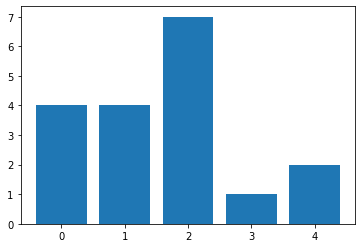

In [60]:
plt.bar(range(5), g.histc(bins=5))

In [61]:
def append_stats(hook, m, i, o): 
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, sds, hists = hook.stats
    mean = o.mean().cpu()
    sd = o.std().cpu()
    hist = o.cpu().histc(40, 0, 10)
    means.append(mean)
    sds.append(sd)
    hists.append(hist)

In [62]:
# Next steps:
# - write a hook that stores the stats of some given activations after each call to `forward`
# - plot those stats across iterations for each layer

In [63]:
runner = get_runner(1e-3, F.cross_entropy, data, [AverageStatsCallback(accuracy, "accuracy"), scheduler])

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [64]:
import pandas as pd

In [65]:
# def plot_hook_means(hook):

In [66]:
runner.fit(1)

accuracy after epoch 0: 0.9674000144004822
Validation loss: 0.1074


In [67]:
runner.fit(1)

accuracy after epoch 0: 0.9768999814987183
Validation loss: 0.0918


accuracy after epoch 0: 0.9793000221252441
Validation loss: 0.0841


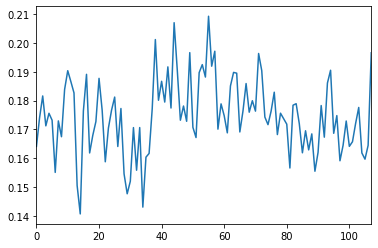

In [69]:
with Hooks(append_stats, runner.learn.model) as h: 
    runner.fit(1)
    pd.Series([i.item() for i in h[0].stats[0]]).plot()
    hist_data = h[0].stats[2]
    initial_hist = hist_data[0].detach().numpy()

<BarContainer object of 40 artists>

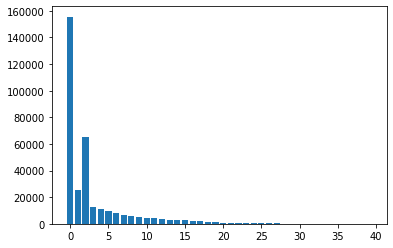

In [70]:
plt.bar(range(len(initial_hist)), initial_hist)

In [72]:
import pandas as pd

# Implement Batch Norm

In [73]:
torch.randn(3,4,5,6).mean(dim=(0,2,3), keepdim=True).size()

torch.Size([1, 4, 1, 1])

In [74]:
# export 
class BatchNorm(nn.Module):
    def __init__(self, nf, eps=1e-5, mom=0.1):
        super().__init__()
        self.eps = eps
        self.mom = mom
        self.gamma = nn.Parameter(torch.ones(nf, 1, 1))
        self.beta = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('mean', torch.zeros(1, nf, 1, 1))
        self.register_buffer('var', torch.ones(1, nf, 1, 1))
        
    def update_stats(self, x):
        mean, var = x.mean(dim=(0,2,3), keepdim=True), x.var(dim=(0,2,3), keepdim=True)
        self.mean.lerp_(mean, self.mom)
        self.var.lerp_(var, self.mom)
        return self.mean, self.var
        
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)  
        else:
            m, v = self.mean, self.var
            
        x_hat = (x - m) / (v + self.eps).sqrt()
        return self.gamma * x_hat + self.beta

In [126]:
# export
def init_cnn_(mdl):
    for layer in mdl.children():
        if isinstance(layer, nn.Conv2d):
            print("initializing conv2d...")
            nn.init.kaiming_normal_(layer.weight)
            if hasattr(layer, 'bias'):
                nn.init.zeros_(layer.bias)
        if isinstance(layer, nn.Sequential): init_cnn_(layer)
            
def conv_layer(ni, nf, size, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, size, stride, padding=size//2),
        GeneralReLU(**kwargs) 
    ]
    # TODO: make running bn an choice via args
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)
    
def get_model():
    conv_layers = [ 
        conv_layer(1, 8, 5),
        conv_layer(8, 16, 3),
        conv_layer(16, 32, 3),
        conv_layer(32, 64, 3),
        conv_layer(64, 10, 3),
    ]
             
    mdl = nn.Sequential(
        *conv_layers,
        nn.AdaptiveAvgPool2d(1),
        nn.LogSoftmax(dim=1),
        Lambda(torch.squeeze)
    ) 
    
    init_cnn_(mdl)
    
    return mdl 

In [76]:
# export
def get_runner(lr, loss, data, cbs): 
    mdl = get_model()
    opt = Adam(mdl.parameters(), lr=lr)
    learn = Learn(mdl, opt, data, loss)
    return Runner(learn, cb_funcs=cbs)

In [77]:
scheduler = CombinedScheduler([0.3, 0.7], CosineScheduler(1e-3, 1, 'lr'), CosineScheduler(1, 1e-3, 'lr'))

In [78]:
runner = get_runner(1e-3, F.cross_entropy, data, [AverageStatsCallback(accuracy, "accuracy"), scheduler])

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [79]:
# runner.learn.model

In [80]:
# runner.fit(10)

This is an enhanced version of the batch normalization layer implemented earlier based on the idea of "running" batch norm as introduced by Jeremy Howard in his "Deep Learning From The Foundations" lectures. It cleans up a few details that we don't quite get right in the implementation above:
* We shouldn't really be linearly interpolating over variances of individual batches, but rather keeping track of the information we need to cumulatively calculate variance. We can do this using the alternative form of the variance equation, $Var[X] = E[X^2] - E[X]^2$. This means we only have to keep track of the X's and the count to compute an accurate variance. 
* This linear interpolation gives far too much importance to the earlier batches. We need to correct for this by applying a debiasing factor to each term in the linearly interpolated sum equivalent to $\frac{1}{1 - (1 - m)^n}$, where $m$ is the momentum argument and $n$ is the batch number. 

In [85]:
import math

In [87]:
torch.tensor([1,2,3]).numel()

3

In [125]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, eps=1e-5, mom=0.1):
        super().__init__()
        self.eps = eps
        self.mom = mom
        self.gamma = nn.Parameter(torch.ones(nf, 1, 1))
        self.beta = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('counts', torch.tensor(0.))
        self.register_buffer('sum', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sum_squares', torch.zeros(1, nf, 1, 1))
        self.register_buffer('mean', torch.zeros(1, nf, 1, 1))
        self.register_buffer('var', torch.ones(1, nf, 1, 1))
        
    def update_stats(self, x):
        self.sum.detach_()
        self.sum_squares.detach_()
        bs,nc,_,_ = x.size()
        # stats specific to batch
        _sum = x.sum(dim=(0,2,3), keepdim=True)
        _sum_squares = (x*x).sum(dim=(0,2,3), keepdim=True)
        _count = _sum.new_tensor(x.numel()/nc)
        _mom = _sum.new_tensor(1 - (1 - self.mom)/(math.sqrt(bs-1)))
        # linearly interpolated states
        self.sum.lerp_(_sum, _mom)
        self.sum_squares.lerp_(_sum_squares, _mom)
        self.counts.lerp_(_count, _mom)
        # compute aggregate mean and var
        self.mean = self.sum / self.counts
        self.var = (self.sum_squares / self.counts) - self.mean * self.mean
        
    def forward(self, x):
        if self.training: self.update_stats(x)  
            
        x_hat = (x - self.mean) / (self.var + self.eps).sqrt()
        return self.gamma * x_hat + self.beta

In [118]:
# RunningBatchNorm(8)(data.train_dl.ds.x)

In [127]:
runner = get_runner(1e-3, F.cross_entropy, data, [AverageStatsCallback(accuracy, "accuracy"), scheduler])

initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...
initializing conv2d...


In [128]:
runner.fit(10)

accuracy after epoch 0: 0.9714999794960022
Validation loss: 0.0969
accuracy after epoch 1: 0.9764000177383423
Validation loss: 0.0876
accuracy after epoch 2: 0.9830999970436096
Validation loss: 0.0775
accuracy after epoch 3: 0.984499990940094
Validation loss: 0.0714
accuracy after epoch 4: 0.9853000044822693
Validation loss: 0.0684
accuracy after epoch 5: 0.9864000082015991
Validation loss: 0.0663
accuracy after epoch 6: 0.9884999990463257
Validation loss: 0.0630
accuracy after epoch 7: 0.9901000261306763
Validation loss: 0.0602
accuracy after epoch 8: 0.9907000064849854
Validation loss: 0.0576
accuracy after epoch 9: 0.9907000064849854
Validation loss: 0.0556
